In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-engagement-disengagement/Final Dataset 256/Disengagement/11-15 Years/Boy/DISENG_11_15_BOY_282.jpg
/kaggle/input/student-engagement-disengagement/Final Dataset 256/Disengagement/11-15 Years/Boy/DISENG_11_15_BOY_517.jpg
/kaggle/input/student-engagement-disengagement/Final Dataset 256/Disengagement/11-15 Years/Boy/DISENG_11_15_BOY_565.jpg
/kaggle/input/student-engagement-disengagement/Final Dataset 256/Disengagement/11-15 Years/Boy/DISENG_11_15_BOY_734.jpg
/kaggle/input/student-engagement-disengagement/Final Dataset 256/Disengagement/11-15 Years/Boy/DISENG_11_15_BOY_363.jpg
/kaggle/input/student-engagement-disengagement/Final Dataset 256/Disengagement/11-15 Years/Boy/DISENG_11_15_BOY_724.jpg
/kaggle/input/student-engagement-disengagement/Final Dataset 256/Disengagement/11-15 Years/Boy/DISENG_11_15_BOY_549.jpg
/kaggle/input/student-engagement-disengagement/Final Dataset 256/Disengagement/11-15 Years/Boy/DISENG_11_15_BOY_264.jpg
/kaggle/input/student-engagement-disenga

In [2]:
import shutil

source_dir = "/kaggle/input/student-engagement-disengagement"

# Destination directory
destination_dir = "/kaggle/working/Dataset"

shutil.copytree(source_dir, destination_dir)

'/kaggle/working/Dataset'

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
                                     GlobalAveragePooling2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [39]:
def parse_filename(filename):
    """Parses the filename to extract age, gender, and engagement/disengagement label."""
    parts = filename.split('_')
    if len(parts) < 5:
        return None  # Skip invalid filenames
    
    # Extract metadata
    label = 1 if "ENG" in parts[0] else 0
    age_group = parts[1]
    gender = 1 if "GIRL" in parts[3].upper() else 0  # 1 for girl, 0 for boy

    # Map age group to numeric values
    age_mapping = {"5": 7.5, "11": 13, "16": 18.5, "22": 25}  # Midpoint of age ranges
    age = age_mapping.get(parts[1].split('-')[0], 0)
    
    return label, age, gender

def load_dataset(base_dir):
    """Loads images and their corresponding metadata from a structured dataset directory."""
    images = []
    labels = []
    ages = []
    genders = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):  # Add valid extensions
                label, age, gender = parse_filename(file)
                if label is not None:
                    filepath = os.path.join(root, file)
                    img = tf.keras.utils.load_img(filepath, target_size=(128, 128))
                    img_array = tf.keras.utils.img_to_array(img) / 255.0

                    images.append(img_array)
                    labels.append(label)
                    ages.append(age)
                    genders.append(gender)

    return np.array(images), np.array(labels), np.array(ages), np.array(genders)


In [40]:
# Replace with your dataset directory
base_dir = '/kaggle/working/Dataset/Final Dataset 256'
images, labels, ages, genders = load_dataset(base_dir)

print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print(f"Ages Shape: {ages.shape}")
print(f"Genders Shape: {genders.shape}")


Images Shape: (16000, 128, 128, 3)
Labels Shape: (16000,)
Ages Shape: (16000,)
Genders Shape: (16000,)


In [41]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
ages_train, ages_val = train_test_split(ages, test_size=0.2, random_state=42)
genders_train, genders_val = train_test_split(genders, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")


Training set size: 12800
Validation set size: 3200


In [2]:
def feature_extractor(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)

    return Model(inputs, x, name='FeatureExtractor')

# Input layers
image_input = Input(shape=(128, 128, 3), name='ImageInput')
age_input = Input(shape=(1,), name='AgeInput')
gender_input = Input(shape=(1,), name='GenderInput')

# Feature extraction
feature_model = feature_extractor((128, 128, 3))
image_features = feature_model(image_input)

# Embeddings for age and gender
age_embedding = Dense(16, activation='relu')(age_input)
gender_embedding = Dense(16, activation='relu')(gender_input)

# Concatenate features
x = Concatenate()([image_features, age_embedding, gender_embedding])

# Fully connected layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[image_input, age_input, gender_input], outputs=output)


In [43]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ImageInput          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AgeInput            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GenderInput         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeatureExtractor    │ (None, 128)       │     94,144 │ ImageInput[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │         32 │ AgeInput[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │         32 │ GenderInput[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160)       │          0 │ FeatureExtractor… │
│ (Concatenate)       │                   │            │ dense_6[0][0],    │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     20,608 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 114,945 (449.00 KB)

 Trainable params: 114,497 (447.25 KB)

 Non-trainable params: 448 (1.75 KB)

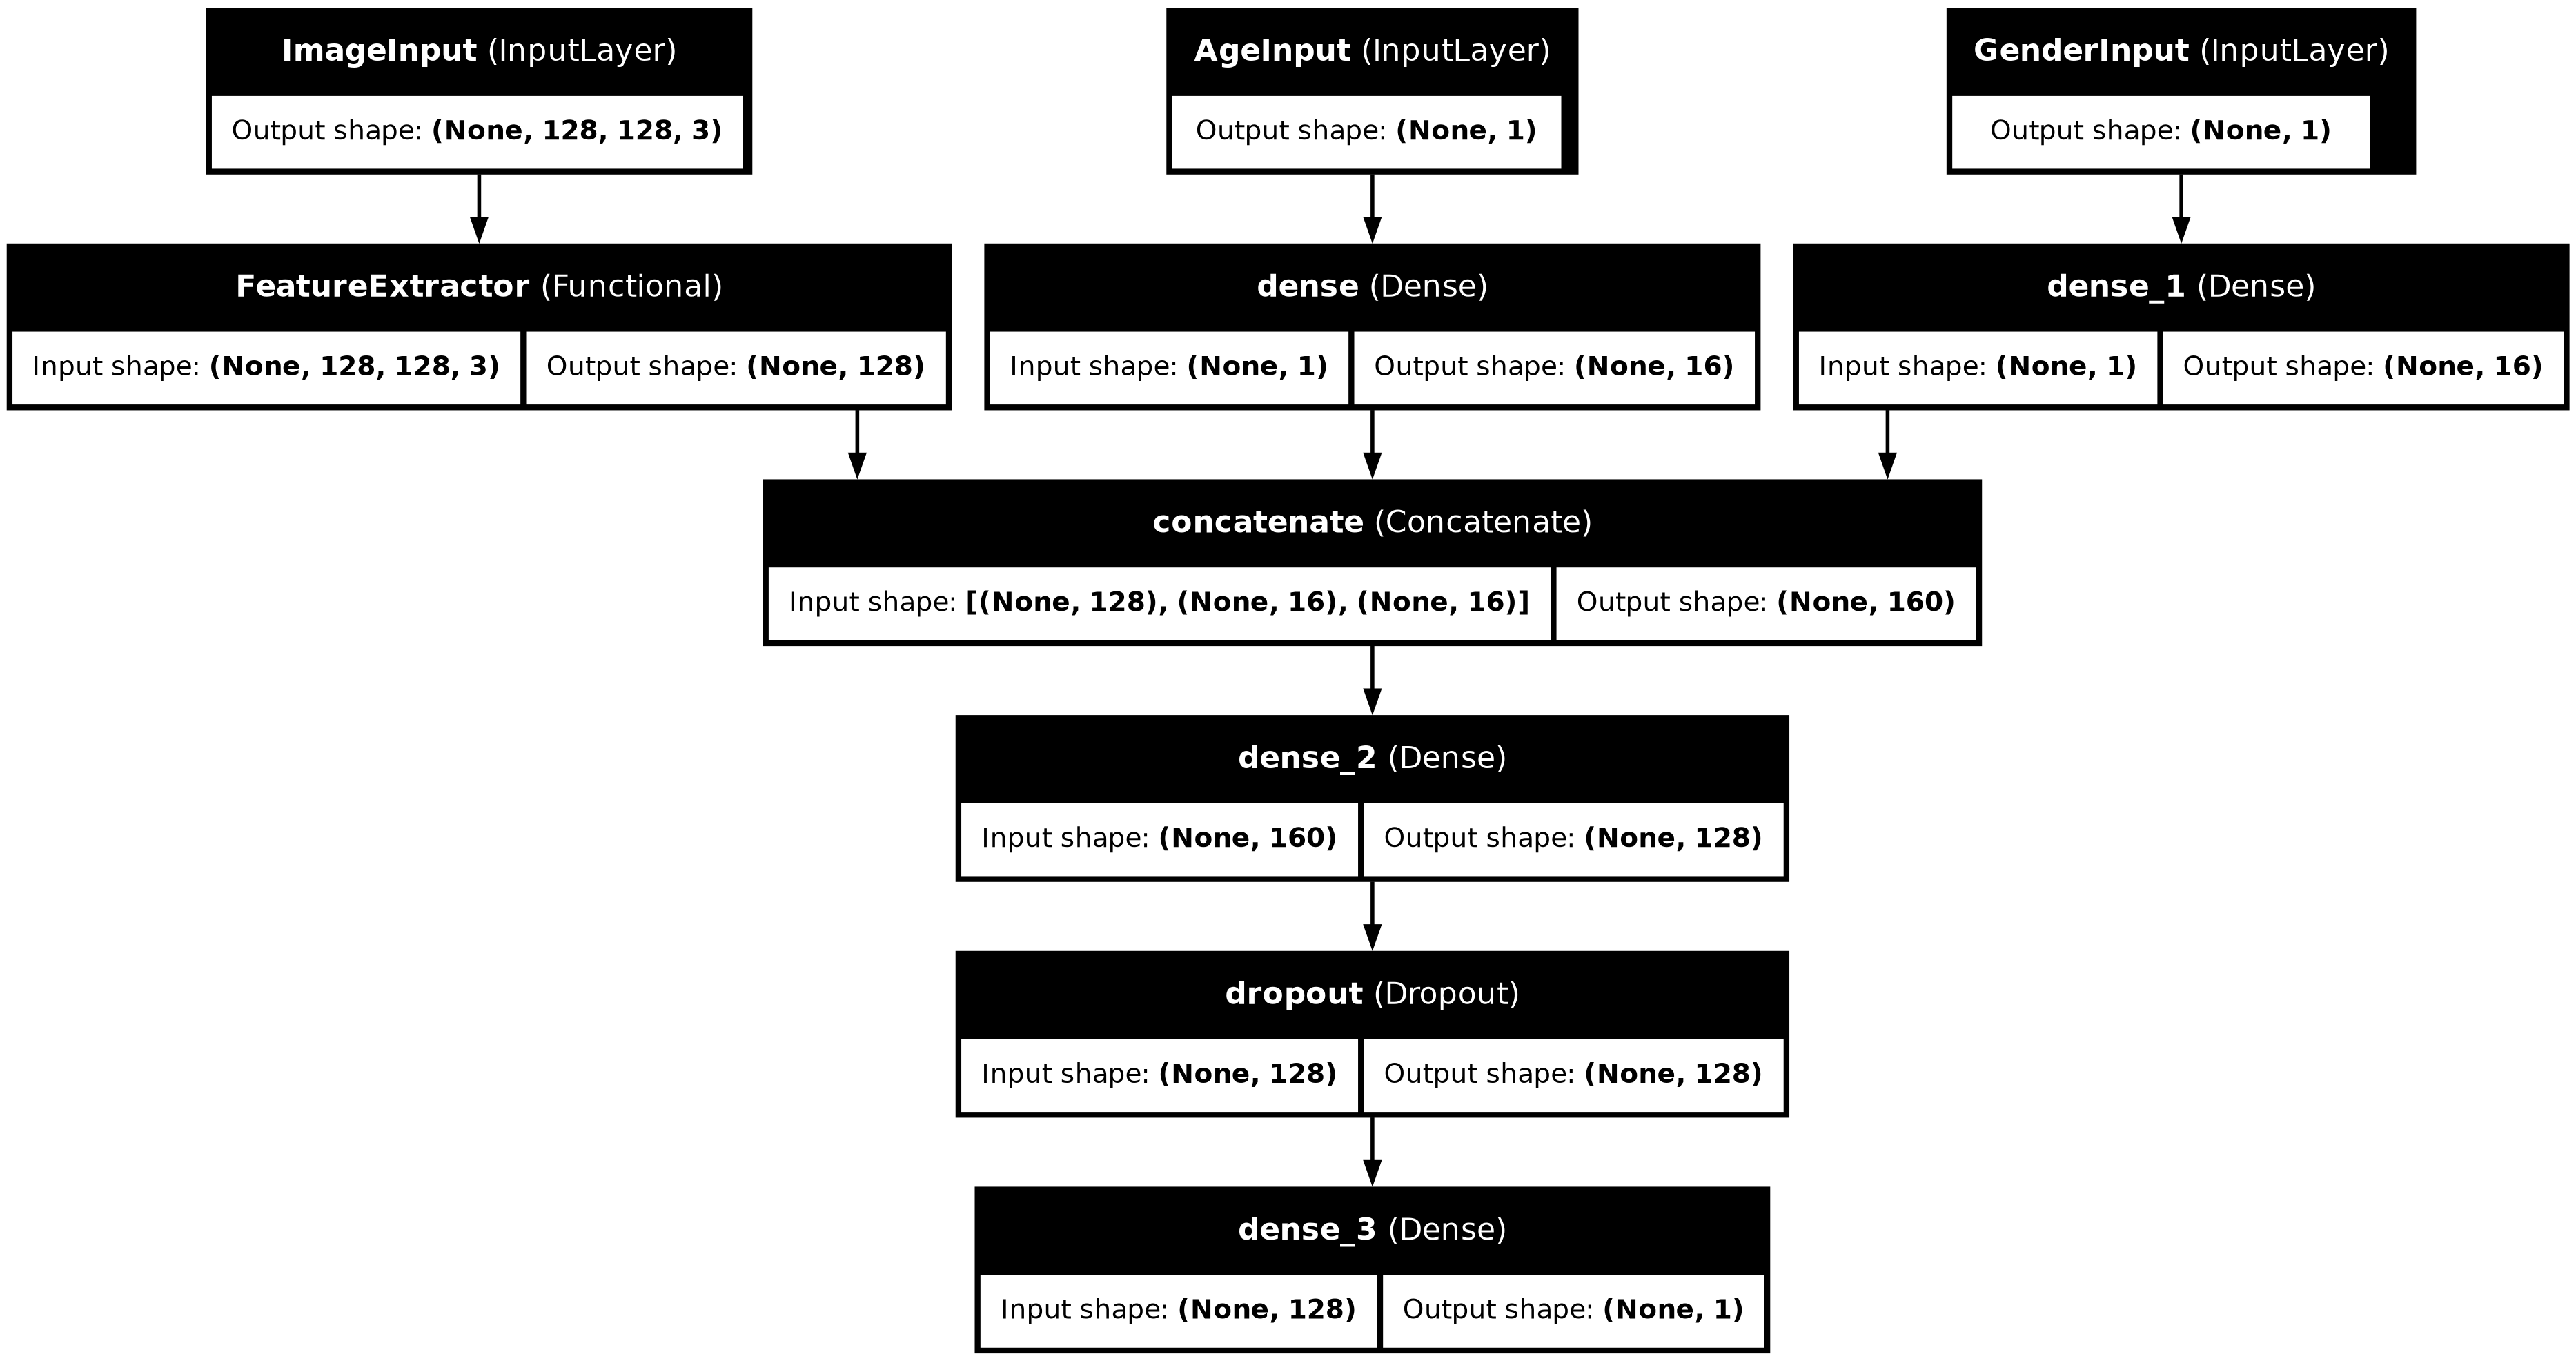

In [3]:
from tensorflow.keras.utils import plot_model

# Save the model architecture as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
from IPython.display import Image
Image('model_architecture.png')


In [44]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

history = model.fit(
    [X_train, ages_train, genders_train], y_train,
    validation_data=([X_val, ages_val, genders_val], y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9288 - loss: 0.1716 - val_accuracy: 0.9413 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9827 - loss: 0.0428 - val_accuracy: 0.9647 - val_loss: 0.0876 - learning_rate: 0.0010
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9908 - loss: 0.0271 - val_accuracy: 0.9472 - val_loss: 0.1572 - learning_rate: 0.0010
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9953 - loss: 0.0125 - val_accuracy: 0.9694 - val_loss: 0.0625 - learning_rate: 0.0010
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9980 - loss: 0.0078 - val_accuracy: 0.9978 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9980 - loss: 0.0048 - val_accuracy: 0.9997 - val_loss: 6.8690e-04 - learning_rate: 0.0010
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9999 - los

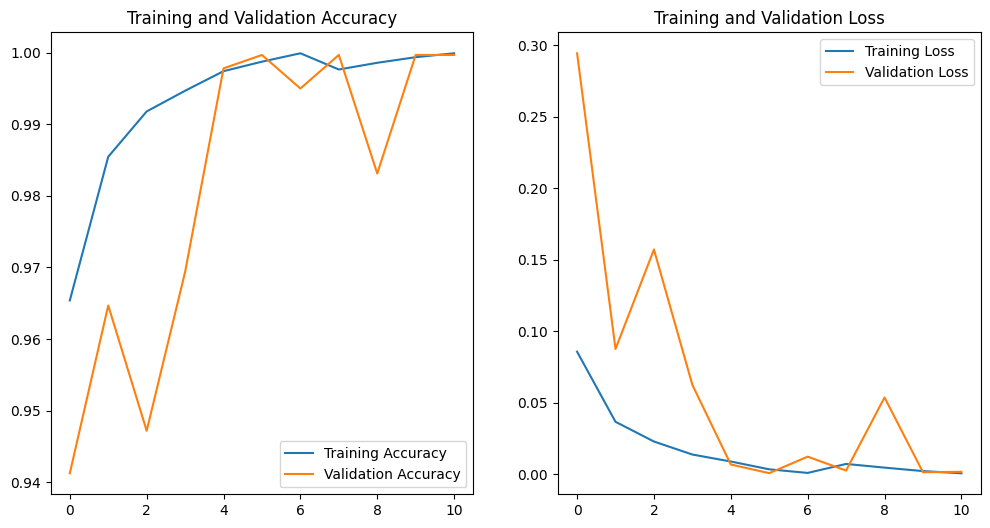

In [45]:
def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_results(history)


In [22]:
class CustomDataGenerator(Sequence):
    def __init__(self, base_path, target_size=(128, 128), batch_size=32, shuffle=True):
        self.base_path = base_path
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_paths = []
        self.labels = []

        # Traverse dataset folders
        for engagement_type in ["Engagement", "Disengagement"]:
            engagement_path = os.path.join(base_path, engagement_type)
            for age_group in os.listdir(engagement_path):
                age_path = os.path.join(engagement_path, age_group)
                for gender in os.listdir(age_path):
                    gender_path = os.path.join(age_path, gender)
                    for img_file in os.listdir(gender_path):
                        img_path = os.path.join(gender_path, img_file)
                        self.image_paths.append(img_path)

                        # Extract labels
                        age_label = map_age_group(age_group)
                        gender_label = map_gender(gender)
                        engagement_label = 0 if engagement_type == "Disengagement" else 1

                        self.labels.append((age_label, gender_label, engagement_label))

        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indexes:
            # Load image
            img = load_img(self.image_paths[i], target_size=self.target_size)
            img = img_to_array(img) / 255.0
            batch_images.append(img)

            # Extract combined labels
            label = self.labels[i]
            batch_labels.append(label)

        # Return formatted data
        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [46]:
model.save('student_engagement_model.keras')


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


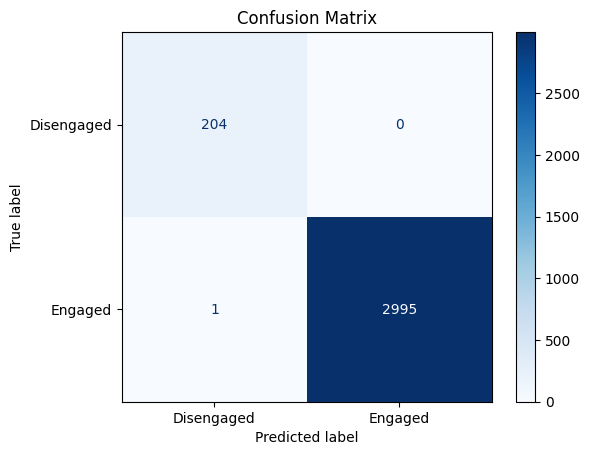

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
y_pred = model.predict([X_val, ages_val, genders_val])
y_pred_labels = (y_pred > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Disengaged", "Engaged"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


<font size="12">NEW CODE TESTING</font>

In [64]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
                                     GlobalAveragePooling2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


In [55]:
def parse_filename(filename):
    """Parses the filename to extract age, gender, and engagement/disengagement label."""
    parts = filename.split('_')
    if len(parts) < 5:
        return None  # Skip invalid filenames
    
    # Extract metadata
    label = 1 if "ENG" in parts[0] else 0
    age_group = parts[1]
    gender = 1 if "GIRL" in parts[3].upper() else 0  # 1 for girl, 0 for boy

    # Map age group to numeric values
    age_mapping = {"5": 7.5, "11": 13, "16": 18.5, "22": 25}  # Midpoint of age ranges
    age = age_mapping.get(parts[1].split('-')[0], 0)
    
    return label, age, gender

def load_dataset(base_dir):
    """Loads images and their corresponding metadata from a structured dataset directory."""
    images = []
    labels = []
    ages = []
    genders = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):  # Add valid extensions
                label, age, gender = parse_filename(file)
                if label is not None:
                    filepath = os.path.join(root, file)
                    img = tf.keras.utils.load_img(filepath, target_size=(128, 128))
                    img_array = tf.keras.utils.img_to_array(img) / 255.0

                    images.append(img_array)
                    labels.append(label)
                    ages.append(age)
                    genders.append(gender)

    return np.array(images), np.array(labels), np.array(ages), np.array(genders)


In [56]:
# Replace with your dataset directory
base_dir = '/kaggle/working/Dataset/Final Dataset 256'
images, labels, ages, genders = load_dataset(base_dir)

print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print(f"Ages Shape: {ages.shape}")
print(f"Genders Shape: {genders.shape}")


Images Shape: (16000, 128, 128, 3)
Labels Shape: (16000,)
Ages Shape: (16000,)
Genders Shape: (16000,)


In [57]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
ages_train, ages_val = train_test_split(ages, test_size=0.2, random_state=42)
genders_train, genders_val = train_test_split(genders, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")


Training set size: 12800
Validation set size: 3200


In [61]:
def feature_extractor(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    return Model(inputs, x, name='FeatureExtractor')

image_input = Input(shape=(128, 128, 3), name='ImageInput')
age_input = Input(shape=(1,), name='AgeInput')
gender_input = Input(shape=(1,), name='GenderInput')

feature_model = feature_extractor((128, 128, 3))
image_features = feature_model(image_input)
age_embedding = Dense(16, activation='relu')(age_input)
gender_embedding = Dense(16, activation='relu')(gender_input)

x = Concatenate()([image_features, age_embedding, gender_embedding])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[image_input, age_input, gender_input], outputs=output)


In [62]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ImageInput          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AgeInput            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GenderInput         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FeatureExtractor    │ (None, 128)       │     94,144 │ ImageInput[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 16)        │         32 │ AgeInput[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │         32 │ GenderInput[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 160)       │          0 │ FeatureExtractor… │
│ (Concatenate)       │                   │            │ dense_18[0][0],   │
│                     │                   │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     20,608 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │        129 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 114,945 (449.00 KB)

 Trainable params: 114,497 (447.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [65]:
class StopAtTargetAccuracy(Callback):
    def __init__(self, target_accuracy):
        super(StopAtTargetAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        if val_accuracy and val_accuracy >= self.target_accuracy:
            print(f"\nReached target accuracy of {self.target_accuracy * 100:.2f}%. Stopping training.")
            self.model.stop_training = True


In [66]:
target_accuracy_callback = StopAtTargetAccuracy(target_accuracy=0.92)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    target_accuracy_callback
]

history = model.fit(
    [X_train, ages_train, genders_train], y_train,
    validation_data=([X_val, ages_val, genders_val], y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/20
396/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9323 - loss: 0.1424
Reached target accuracy of 92.00%. Stopping training.
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9328 - loss: 0.1416 - val_accuracy: 0.9362 - val_loss: 0.2972 - learning_rate: 0.0010


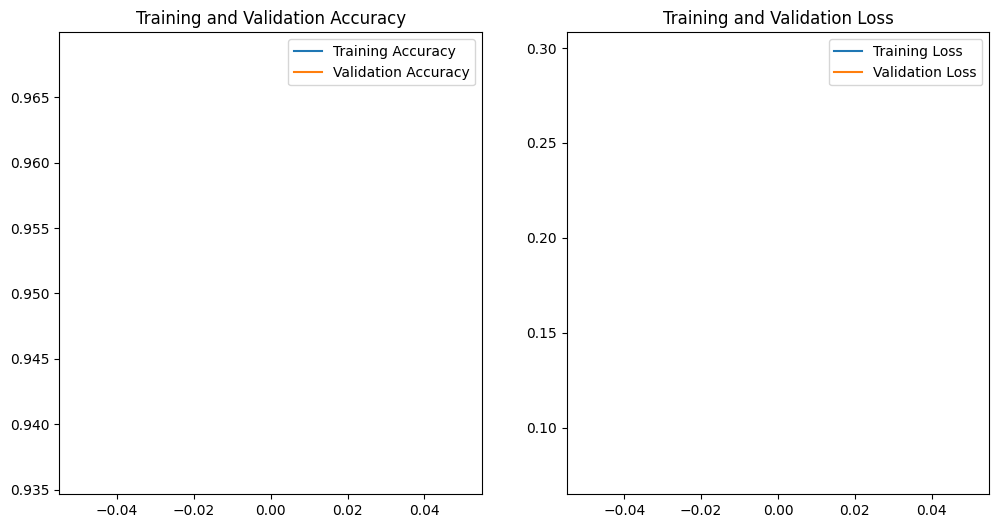

In [67]:
def plot_training_results(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_results(history)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


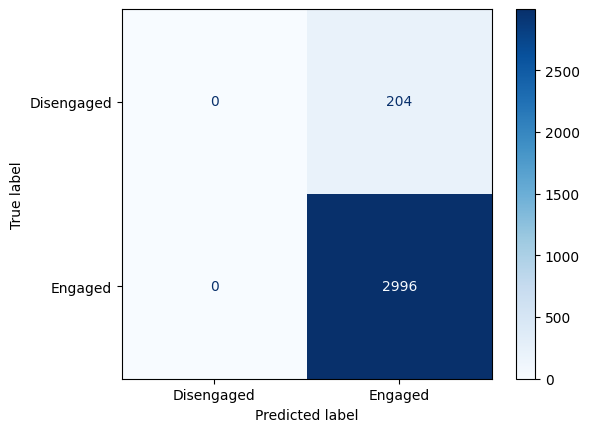

Classification Report:
              precision    recall  f1-score   support

  Disengaged       0.00      0.00      0.00       204
     Engaged       0.94      1.00      0.97      2996

    accuracy                           0.94      3200
   macro avg       0.47      0.50      0.48      3200
weighted avg       0.88      0.94      0.91      3200



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [68]:
y_pred = (model.predict([X_val, ages_val, genders_val]) > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Disengaged', 'Engaged'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Disengaged', 'Engaged']))
